# Implement experimental data collection and analyses
**What does this script do?** 
This script collects langauge model responses to experimental prompts, classifies them through the Google Jigsaw 
API bridging attributes, and analyses the outputs. 

**What do future users need to know?** 
This includes collecting model responses from a series of different API providers. 
Each future user of this script needs to define their own keys (and securely save them)
in order to be able to run the code below. For each API provier, calls to separate language models 
were made, as described below the title of each provider. The code is setup such that 
each request loop needs to be run separately for each language model, and the language model names need to 
be manually adapted accordingly. With time, language model versions may be deprecated and their availability
needs to be checked on respective provider websites before use. 

If you want more details on how the API requests are being made, please see the experimental_analyses_api_calls.py
file in the host GitHub repo to find the sourced functions. 

**How are the data setup?**
In the script below, the dataset called 01_prompts_for_experimental_manipulation.csv is loaded into prompts_df.
This contains one column called user_prompt, with the original interrogatives that PRISM participants (Kirk et al., 2024) 
asked. For each of these rows, a counterfactual_prompt was manually written by the main author. Therfore, in this dataframe
each row contains a prompt pair. Reseponses for these prompt pairs are then collected from a series of commercial LLMs, and analysed. 

Half of the PRISM user_prompts are classified as whathow_q's and the other half as hobsons_c's. For each row, the counterfactual
created contains the opposite question type. In addition, for each counterfactual prompt, there is a prompt_template (to control for
LM prompt sensitivity in the generated responses), and the formulation of the counterfactual prompts depends on the defined prompts.  

**How is this notebook structured?**

0. Setup
1. OpenAI API
2. Anthropic API
3. MistralAI API
4. Google API
5. Together AI API 
6. Create full dataset with all LLM responses combined
7. Sense check the dataset & do some pre-processing
8. Get LLM response attributes with Perspective Jigsaw API
9. Descriptive analyses - response length
10. Qualitative – Chat GPT Case Study
11. Quantitative - Visualise quantitative results 

# 0. Setup

In [1]:
##############################################
# Code implemented on:
# - Python Version: 3.11.11
# - Last modified: 07.08.2025
##############################################

################### Imports #################
import os
import re
import sys
import time
import json
import requests
import keyring
import tiktoken
import pandas as pd
import numpy as np
import anthropic
import seaborn as sns
import matplotlib as mpl
from openai import OpenAI
from tabulate import tabulate
from scipy.stats import levene
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.lines import Line2D
import google.generativeai as genai
from scipy.stats import ttest_rel
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap



################### Configs #################
np.random.seed(89)

# Throughout this script, API keys are managed with keyring. Future users need to
# define their own keys for each respective API provider and set them once using the code below.  
# keyring.set_password("provider_name", "key_name", "secret_key_you_should_not_show_to_anyone")


################### Define paths #################
# Project root
PROJECT_ROOT = "/Users/carolinewagner/Desktop/Local/MY498-capstone-main"

classified_path = os.path.join(PROJECT_ROOT, 
                               "01_data", 
                               "07_final_classified_data", 
                               "final_classified_data.jsonl")

EXPERIMENT_IMPLEMENTATION_DIR = os.path.join(PROJECT_ROOT, 
                                             "01_data", 
                                             "09_experimental_implementation")

# Path to model responses folder
MODEL_RESPONSES_DIR = os.path.join(EXPERIMENT_IMPLEMENTATION_DIR, 
                                   "02_model_responses")

# Create the directory if it doesn't exist
os.makedirs(MODEL_RESPONSES_DIR, exist_ok=True)

# Define the path to the CSV file with prompt pairs 
PROMPTS_CSV_PATH = os.path.join(EXPERIMENT_IMPLEMENTATION_DIR,
                                "01_prompts_for_experimental_manipulation.csv")

# Where is the file with all the combined LLM responses to be saved? 
combined_path = os.path.join(MODEL_RESPONSES_DIR, 
                             "all_model_responses_combined.jsonl")

# Where should results from analyses be saved (dfs that are not yet formatted)?
RESULTS_PATH = os.path.join(PROJECT_ROOT,
                            "01_data",
                            "10_experimental_results") 

EXPERIMENTAL_DATA_PATH = os.path.join(
    EXPERIMENT_IMPLEMENTATION_DIR,
    "final_experimental_data.jsonl"
)

# Where should output figures be saved? 
FIGURES_PATH = os.path.join(PROJECT_ROOT, 
                               "03_outputs", 
                               "03_experimental_analyses")

# Where should appendices be saved?
APPENDICES_PATH = os.path.join(PROJECT_ROOT, 
                               "03_outputs", 
                               "04_appendices")


################### Import helper functions #################
# Add the helper folder to the system path
sys.path.append(os.path.abspath("01_helper-functions"))

from experimental_analyses_api_calls import *
from general_python_helper import *


################### Toggles #################
# Set the toggle below to True if you want the figures generated in this script to automatically 
# be saved ot the directory for descriptive analyses outputs defined above.
to_save = True 


################### Import & clean data #################
# Load the dataset with the user_prompts from Kirk et al.'s (2024) PRISM dataset, and the
# counterfactual prompts required for these experimental analyses written by the main author of this project. 

# (1) Load the CSV into a pandas DataFrame
# If locally editing the csv file using e.g., excel, make sure to save it with UTF-8 encoding. 
prompts_df = pd.read_csv(PROMPTS_CSV_PATH, encoding='utf-8')

# (2) Strip whitespace and normalize text
prompts_df["counterfactual_prompt"] = prompts_df["counterfactual_prompt"].astype(str).str.strip()

# (3) Replace all known invalid string values
# This will be for example when he original prompt was misclassified. 
invalid_strings = ["", "NA", "na", "Na", "N/A", "n/a", "nan"]
prompts_df["counterfactual_prompt"] = prompts_df["counterfactual_prompt"].replace(invalid_strings, pd.NA)

# (4) Drop true missing values
before = len(prompts_df)
prompts_df = prompts_df.dropna(subset=["counterfactual_prompt"])
after = len(prompts_df)

print(f"Rows before cleaning: {before}")
print(f"Rows after cleaning:  {after}")
print(f"Rows dropped:         {before - after}")

# (5) Drop 10 rows which got classified into both categories.
# This stems from a previous implementation of the operationalisation where the
# categories were not yet mutually exclusive - this has been fixed throughout the
# analyses, and does not influence the implementation of this experiment. 
prompts_df = prompts_df[~((prompts_df['hobsons_c_debiased'] == 1) & 
                          (prompts_df['whathow_q_debiased'] == 1))]


# (5) Randomly reshuffling them, so there is no bias from the structure that facilitated the manual formulation of counterfactual
# (even though that would be unlikely)
prompts_df = prompts_df.sample(frac=1, random_state=89).reset_index(drop=True)

Rows before cleaning: 550
Rows after cleaning:  437
Rows dropped:         113


In [2]:
# Get an understanding of the experimental implementation after filtering out NAs. 

# (1) get the distribution of the templates in different numbers
whathow_counts = prompts_df[prompts_df['whathow_q_debiased'] == 1]['prompt_template'].value_counts()
print("Prompt template counts for whathow_q == 1:")
print(whathow_counts)

hobsons_counts = prompts_df[prompts_df['hobsons_c_debiased'] == 1]['prompt_template'].value_counts()
print("\nPrompt template counts for hobsons_c == 1:")
print(hobsons_counts)

# (2) Check how many rows are missing the counterfactual prompt
missing_counterfactual = prompts_df['counterfactual_prompt'].isna().sum()
print(f"Rows missing counterfactual_prompt: {missing_counterfactual}")

# (3) Total number of What/How prompts
whathow_total = prompts_df[prompts_df['whathow_q_debiased'] == 1]['prompt_template'].value_counts().sum()
print(f"Total What/How prompts: {whathow_total}")

# (4) Total number of Hobson's Choice prompts
hobsons_total = prompts_df[prompts_df['hobsons_c_debiased'] == 1]['prompt_template'].value_counts().sum()
print(f"Total Hobson's Choice prompts: {hobsons_total}")

# Notice that there is a different number of WH templates compared to HC  -
# HC has more uncertainty and therefore more misclassified prompts. But this does not
# influence downstream analyses because the overall number of prompt pairsstil exceeds 400. 

Prompt template counts for whathow_q == 1:
prompt_template
3    56
0    54
1    45
4    44
2    40
Name: count, dtype: int64

Prompt template counts for hobsons_c == 1:
prompt_template
3    43
0    41
4    41
1    37
2    26
Name: count, dtype: int64
Rows missing counterfactual_prompt: 0
Total What/How prompts: 239
Total Hobson's Choice prompts: 188


# 1. OpenAI API
This is to be run on these models:
- gpt-4.1-2025-04-14 [Reasoning – NO]
- gpt-4.1-mini-2025-04-14 [Reasoning – NO]
- gpt-4.1-nano-2025-04-14 [Reasoning – NO]
- o4-mini-2025-04-16 [Reasoning – YES]

In [ ]:
# (1) Authenticate
api_key = keyring.get_password("openai", "capstone_collect_responses")
client = OpenAI(api_key=api_key)

# (2) Define model and output file path
# Models to loop through "gpt-4.1-mini"; "gpt-4.1-nano", "gpt-4.1", "o4-mini"

model_name = "o4-mini"
output_path = os.path.join(MODEL_RESPONSES_DIR, f"openai_{model_name}.jsonl")

# (3) Loop through rows and send a chosen source of prompt
# For each model, the loop needs to be run once for user_prompt, and once for counterfactual_prompt.
# Hashed out line below is to test the API calls on a smaller subset of the data for testing the code. 
#for i, row in prompts_df.iloc[:9].iterrows():
for i, row in prompts_df.iterrows():
    try:
         # Needs to be run for 'user_prompt' AND 'counterfactual_prompt' separately. 
        prompt_source = "counterfactual_prompt"
        prompt_text = row[prompt_source]

        response_text, metadata = openai_call_model(prompt_text, model=model_name)
        record = build_record(row, response_text, metadata, prompt_source)
        save_record_to_jsonl(record, output_path)
        print(f"Saved row {i+1} using {prompt_source} to {output_path}")

        # Add some sleep to respect server load 
        time.sleep(1)

    except Exception as e:
        print(f"Error on row {i+1}: {e}")

In [ ]:
################### General note #################

# After running each loop of calls to a given API throughout this document, 
# you may want to run the few lines of code below if you want to direclty 
# look at your outputs locally in a .csv file - allows to sense check that 
# calls are being implemented as intended. 

# Read in the json lines document to see if everything is working as intended: 
df = pd.read_json(output_path, lines=True)

print(df.head())       # View first few rows
print(df.columns)      # View column names
print(df.shape)        # See number of rows/columns

csv_output_path = output_path.replace(".jsonl", ".csv")
df.to_csv(csv_output_path, index=False)

# 2. Anthropic API
This is to be run on these models:
- claude-3-haiku-20240307 [Reasoning – NO]
- claude-3-opus-20240229 [Reasoning – NO]
- claude-sonnet-4-20250514 [Reasoning – YES]


In [ ]:
# (1) Authenticate
api_key = keyring.get_password("anthropic", "capstone_collect_responses")
client = anthropic.Anthropic(api_key=api_key)

# (2) Define model and output file path
model_name = "claude-3-opus-20240229"
output_path = os.path.join(MODEL_RESPONSES_DIR, f"anthropic_{model_name}.jsonl")

# (3) Loop through prompts and collect responses
# This uses the sourced and pre-defined functions. 
# Again, example hashed out code for testing the calls. 
#for i, row in prompts_df.iloc[:2].iterrows():
for i, row in prompts_df.iterrows():
    try:
        prompt_source = "user_prompt"  # Needs to be run for 'user_prompt' AND 'counterfactual_prompt' separately for each model. 
        prompt_text = row[prompt_source]

        response_text, metadata = anthropic_call_model(prompt_text, model=model_name)
        record = build_record(row, response_text, metadata, prompt_source)
        save_record_to_jsonl(record, output_path)
        print(f"Saved row {i+1} using {prompt_source} to {output_path}")

        # Add some sleep to respect server load 
        time.sleep(2)

    except Exception as e:
        print(f"Error on row {i+1}: {e}")

Saved row 1 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone/01_data/09_experimental_implementation/02_model_responses/anthropic_claude-3-opus-20240229.jsonl
Saved row 2 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone/01_data/09_experimental_implementation/02_model_responses/anthropic_claude-3-opus-20240229.jsonl
Saved row 3 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone/01_data/09_experimental_implementation/02_model_responses/anthropic_claude-3-opus-20240229.jsonl
Saved row 4 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone/01_data/09_experimental_implementation/02_model_responses/anthropic_claude-3-opus-20240229.jsonl
Saved row 5 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone/01_data/09_experimental_implementation/02_model_responses/anthropic_claude-3-opus-20240229.jsonl
Saved row 6 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone/01_data/09_

# 3. MistralAI API
This is to be run on these models:
- mistral-medium-latest   = mistral-medium-2505 [Reasoning – NO]
- mistral-small [Reasoning – NO]
- magistral-medium-2506 [Reasoning – YES]

In [ ]:
# (1) Authenticate
api_key = keyring.get_password("mistral", "capstone_collect_responses")

# (2) Define model and output file path
# Models to run this for: magistral-medium-2506 - latest mistral reasoning model
# mistral-medium-latest (at the time of running this experiment, july 2025, this points to mistral-medium-2505)
# mistral-small (at the time of running this experiment, july 2025, this points to mistral-small-2506)

model_name = "magistral-medium-2506"
output_path = os.path.join(MODEL_RESPONSES_DIR, f"mistral_{model_name}.jsonl")

# (3) Endpoint
MISTRAL_API_URL = "https://api.mistral.ai/v1/chat/completions"
HEADERS = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

# (4) Loop to send prompts and store responses
# Hashed out code below for testing implementation. 
for i, row in prompts_df.iloc[314:].iterrows():
#for i, row in prompts_df.iterrows():
    try:
        prompt_source = "user_prompt"  # Needs to be run for 'user_prompt' AND 'counterfactual_prompt' separately for each model. 
        prompt_text = row[prompt_source]

        response_text, metadata = mistralai_call_model(prompt_text, model=model_name, url=MISTRAL_API_URL, headers=HEADERS)
        record = build_record(row, response_text, metadata, prompt_source)
        save_record_to_jsonl(record, output_path)
        print(f"Saved row {i+1} using {prompt_source} to {output_path}")

        # Add some sleep to respect server load 
        time.sleep(2)  

    except Exception as e:
        print(f"Error on row {i+1}: {e}")

Saved row 315 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone-main/01_data/09_experimental_implementation/02_model_responses/mistral_magistral-medium-2506.jsonl
Saved row 316 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone-main/01_data/09_experimental_implementation/02_model_responses/mistral_magistral-medium-2506.jsonl
Saved row 317 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone-main/01_data/09_experimental_implementation/02_model_responses/mistral_magistral-medium-2506.jsonl
Saved row 318 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone-main/01_data/09_experimental_implementation/02_model_responses/mistral_magistral-medium-2506.jsonl
Saved row 319 using user_prompt to /Users/carolinewagner/Desktop/Local/MY498-capstone-main/01_data/09_experimental_implementation/02_model_responses/mistral_magistral-medium-2506.jsonl
Saved row 320 using user_prompt to /Users/carolinewagner/Desktop/Local/MY49

# 4. Google API
Ran this for the following models: 
- "gemini-1.5-pro" - run for both counterfactual and user prompt
- "gemini-2.5-flash" - run for counterfactual prompt


In [ ]:
# (1) Authenticate using keyring
api_key = keyring.get_password("google", "capstone_collect_responses")
genai.configure(api_key=api_key)

# (2) Define model and output path
model_name = "gemini-2.5-flash"
output_path = os.path.join(MODEL_RESPONSES_DIR, f"google_{model_name}.jsonl")

# (3) Load the Gemini model
model = genai.GenerativeModel(model_name)

# (4) Implement loop through dataset
# Hashed out code to test implementation for a few rows. 
#for i, row in prompts_df.iloc[22:].iterrows():  
for i, row in prompts_df.iterrows():

    try:
        prompt_source = "user_prompt"  # this needs to be run separately for "user_prompt" and "counterfactual_prompt"
        prompt_text = row[prompt_source]

        # (a) Call Gemini model
        response_text, metadata = google_call_model(prompt_text, model)

        # (b) Build record and save
        record = build_record(row, response_text, metadata, prompt_source)
        save_record_to_jsonl(record, output_path)

        print(f"Saved row {i+1} using {prompt_source} to {output_path}")
        
        # (c) Add some sleep to respect server load 
        time.sleep(2)  

    except Exception as e:
        print(f"Error on row {i+1}: {e}")

# 5. Together AI API (provider to access Meta and Deepseek Models)
This will be run on hte following models:

Deepseek: 
-	deepseek-ai/DeepSeek-R1 [Reasoning – YES] - (run on counterfactual_prompt & user_prompt)
-	deepseek-ai/DeepSeek-R1-0528-tput [Reasoning – YES] (5028 is a more advanced model than simply R1) - (run on user_prompt & counerfactual prompt)

Meta:
-	meta-llama/Meta-Llama-3-8B-Instruct-Lite - [Reasoning – YES] - (run on counterfactual_prompt & user_prompt)
-	meta-llama/Llama-4-Scout-17B-16E-Instruct [Reasoning – YES] - (run on counterfactual_prompt & user_prompt)
-	meta-llama/Llama-3.3-70B-Instruct-Turbo [Reasoning – YES] - (run on counterfactual_prompt & user_prompt)

Google: 
- google/gemma-2-27b-it - (run on counterfactual_prompt & user_prompt)
- google/gemma-3n-E4B-it - (run on counterfactual_prompt & user_prompt)

Qwen:
- Qwen/Qwen2.5-72B-Instruct-Turbo - (run on counterfactual_prompt & user_prompt)
- Qwen/QwQ-32B - (run on counterfactual_prompt & user_prompt)

In [ ]:
# Implement the main loop to make calls to the Together AI API. 
# (1) Define output path. Again model names need to be adapted at each run of this loop to the ones in the rmd chunk above. 
model_name = "Qwen/QwQ-32B"
output_path = os.path.join(MODEL_RESPONSES_DIR, f"{model_name.replace('/', '_')}.jsonl")

# (2) Implement loop to make calls
# Hashed out code for testing the loop on a few rows
#for i, row in prompts_df.iloc[172:].iterrows():
for i, row in prompts_df.iterrows():
    row = prompts_df.iloc[i]

    try:
        prompt_source = "counterfactual_prompt"  # run on "user_prompt" AND "counterfactual_prompt"
        prompt_text = row[prompt_source]

        response_text, metadata = together_call_model(prompt_text, model=model_name)
        record = build_record(row, response_text, metadata, prompt_source)
        save_record_to_jsonl(record, output_path)
        print(f"Saved row {i+1} using {prompt_source} to {output_path}")

        # Add some sleep to respect server load (high rate limits for DeepSeek LLMs)
        time.sleep(15)  

    except Exception as e:
        print(f"Error on row {i+1}: {e}")

# 6. Create full dataset with all LLM responses combined

In [ ]:
# (1) Define model responses directory
combined_data = []
for filename in os.listdir(MODEL_RESPONSES_DIR):

    # Make sure the combined file does not get added if it already exists in the dir 
    if filename.endswith(".jsonl") and not filename.startswith("all_model_responses_combined"):
        file_path = os.path.join(MODEL_RESPONSES_DIR, filename)

        # Extract provider and model from filename
        base_name = filename.replace(".jsonl", "")
        parts = base_name.split("_", 1)
        if len(parts) == 2:
            model_provider, model_name = parts
        else:
            model_provider, model_name = "unknown", base_name  # fallback if unexpected format

        # Read the .jsonl file into a DataFrame
        with open(file_path, "r", encoding="utf-8") as f:
            rows = [json.loads(line) for line in f]

        df = pd.DataFrame(rows)
        df["model_provider"] = model_provider
        df["model_name"] = model_name

        combined_data.append(df)

# (2) Combine all into a single DataFrame
all_models_df = pd.concat(combined_data, ignore_index=True)

# (3) have a look 
print(all_models_df.shape)
print(all_models_df[["model_provider", "model_name"]].drop_duplicates())

# (4) Save to jsonl
all_models_df.to_json(os.path.join(MODEL_RESPONSES_DIR, "all_model_responses_combined.jsonl"), 
                      orient="records", lines=True, force_ascii=False)


(18288, 11)
      model_provider                      model_name
0            mistral                   mistral-small
874           google                  gemma-2-27b-it
1748          google                 gemma-3n-E4B-it
2622          openai                         o4-mini
3497          google                gemini-2.5-flash
4367          openai                         gpt-4.1
5241          openai                    gpt-4.1-mini
6115            Qwen      Qwen2.5-72B-Instruct-Turbo
6989     deepseek-ai                     DeepSeek-R1
7864      meta-llama    Llama-3.3-70B-Instruct-Turbo
8737            Qwen                         QwQ-32B
9611       anthropic        claude-sonnet-4-20250514
10485    deepseek-ai           DeepSeek-R1-0528-tput
11359     meta-llama  Llama-4-Scout-17B-16E-Instruct
12233        mistral           mistral-medium-latest
13106        mistral           magistral-medium-2506
13918     meta-llama   Meta-Llama-3-8B-Instruct-Lite
14791      anthropic         claud

# 7. Sense check the dataset & do some pre-processing

In [ ]:
##############################################
# Extract reasoning tokens 
##############################################

# (1) Load the jsonl document with all the model responses for analyses.
# (this is just so that teh code can be run separately, and the dataset doesn't have to be recreated everytime)
all_models_df = pd.read_json(combined_path, lines=True)

# (2) Apply function that extracts 'thinking' from the reasoning model outputs
# into a separate column to avoid confounding analyses. 
all_models_df[['reasoning_output', 'model_response']] = all_models_df['model_response'].apply(
    extract_reasoning_and_strip_all
)

In [ ]:
##############################################
# Pre-process LLM response pairs
##############################################

# (1) The counterfactuals were created before I explicitly defined the final response classification function to
# assign mutually exclusive categories. Therefore, a few rows may have been assigned two categories due to misclassifications. 
# To ensure the implementation here is consistent with the rest of the project, I am implementing this manually below. 
all_models_df = all_models_df[~((all_models_df['whathow_q_debiased'] == 1) & 
                                (all_models_df['hobsons_c_debiased'] == 1))]

# (a) How many rows have both a 1 for hobsons choice and whathow questions?
both_ones = all_models_df[
    (all_models_df['hobsons_c_debiased'] == 1) & 
    (all_models_df['whathow_q_debiased'] == 1)
]
print(f"Rows with both == 1: {len(both_ones)}")

# (b) How many rows have both a 0 for hobsons choice and whathow questions? 
both_zeros = all_models_df[
    (all_models_df['hobsons_c_debiased'] == 0) & 
    (all_models_df['whathow_q_debiased'] == 0)
]
print(f"Rows with both == 0: {len(both_zeros)}")

# (2) Checking the final number of prompt template pairs
print(f"Number of prompt template pairs: {prompts_df['utterance_id'].nunique()}")

# (3) Remove all the rows that only have one model response per pair (within each model_name)
# For these rows, there must have been an error e.g., through rate limits in collecting the second response. 
# Filter out rows where (model_name, utterance_id) appears only once
before = len(all_models_df)
all_models_df = all_models_df.groupby(['model_name', 'utterance_id']).filter(lambda x: len(x) > 1)
after = len(all_models_df)

# How many rows were dropped?
print(f"Rows dropped: {before - after}")

# (4) There are 12 rows that have 3 model responses per pair (one too many was collected)
# Dropping the second one of the redundant duplicate

# (a) Tag each (model_name, utterance_id) group with a count
group_sizes = all_models_df.groupby(['model_name', 'utterance_id'])['prompt_source'].transform('count')

# (b) Filter to only the rows in groups with exactly 3 responses
triplets_df = all_models_df[group_sizes == 3]

# (c) Within those, keep only the first of each prompt_source per group
deduped_triplets = triplets_df.sort_values(by=['model_name', 'utterance_id']).drop_duplicates(
    subset=['model_name', 'utterance_id', 'prompt_source'], keep='first'
)

# (d) Drop the original triplet rows from all_models_df and replace with deduped
before = len(all_models_df)

all_models_df = pd.concat([
    all_models_df.drop(triplets_df.index),
    deduped_triplets
], ignore_index=True)

after = len(all_models_df)

# (e) Print how many rows were dropped
print(f"Rows dropped: {before - after}")

# (5) Do any rows have NAs in model_response?
num_nans = all_models_df['model_response'].isna().sum()
print(f"Number of rows with NaN in model_response: {num_nans}")

# (6) Check data filtering - how many responses per utterance_id per model?
counts = all_models_df.groupby(['model_name', 'utterance_id']).size().reset_index(name='n')
print(counts['n'].value_counts())

# (7) What is the final numer of LLM responses to be analysed?  
print(f"Total LLM responses: {len(all_models_df)}")

# For report: total number of responses dropped = 75 + 12 = 87
# Of the 75, a lot are coming from mistral magistral

Rows with both == 1: 0
Rows with both == 0: 0
Number of prompt template pairs: 427
Rows dropped: 75
Rows dropped: 12
Number of rows with NaN in model_response: 0
n
2    8892
Name: count, dtype: int64
Total LLM responses: 17784


In [10]:
##############################################
# Make column with prompt type fed to LLM
##############################################

# (A) Each row in all_models_df represents an LLM response to either the user_prompt or the counterfactual_prompt.
# The original debiasing flags (whathow_q_debiased, hobsons_c_debiased) describe the user_prompt only.
# To correctly identify what type of prompt the model was actually fed in a given row, I reconstruct it using both the prompt_source and the original flags.
# prompt_source has counterfactual prompts, and user_prompts, but some of them are respectively hobsons c and others what/how; given how the counterfactual
# prompts were created. 

# (0) This function is left in the main script and not sourced so that future users can more easily understand the underlying logic. 
def infer_model_fed_q_type(row):

    """If the prompt is the original user_prompt, it is classified directly based on its label—either 'hobsons_c' if 
    hobsons_c_debiased == 1, or 'whathow_q' otherwise. For counterfactual_prompts, the classification is inverted: 
    if the original was 'hobsons_c', the counterfactual is labeled 'whathow_q', and vice versa - in accordance
    with how the counterfactuals were created. Note that this structure is because the hobsons_c_debiased and whathow_q_debiased
    indicate teh prompt type for the user_prompt."""

    if row['prompt_source'] == 'user_prompt':
        return 'hobsons_c' if row['hobsons_c_debiased'] == 1 else 'whathow_q'
    elif row['prompt_source'] == 'counterfactual_prompt':
        return 'whathow_q' if row['hobsons_c_debiased'] == 1 else 'hobsons_c'
    else:
        return 'UNKNOWN'
    
# (1) Apply function. 
all_models_df['model_fed_q_type'] = all_models_df.apply(infer_model_fed_q_type, axis=1)

# (2) Check that this was implemented as intended.
print(all_models_df.groupby(['prompt_source', 'model_fed_q_type']).size())

prompt_source          model_fed_q_type
counterfactual_prompt  hobsons_c           4982
                       whathow_q           3910
user_prompt            hobsons_c           3910
                       whathow_q           4982
dtype: int64


In [ ]:
##############################################
# Get all response lengths with same tokeniser
##############################################

# (1) This is done because different models and different providers use different 
# tokenisers, token lengths are not comparable across LLMs otherwise. 
encoding = tiktoken.encoding_for_model("gpt-4")
all_models_df['tokens'] = all_models_df['model_response'].apply(lambda x: count_tokens(x, encoding))

# (2) Save the final cleaned datafile (this structure is again so that different 
# parts of this script can be run separarely given relatively long running times)
all_models_df.to_json(combined_path, orient='records', lines=True, force_ascii=False)


# 8. Get LLM response attributes with Perspective Jigsaw API

In [ ]:
##############################################
# Setup
##############################################

# (1) Load the file
all_models_df = pd.read_json(combined_path, orient='records', lines=True)

# (2) Setup Perspective API
api_key = keyring.get_password("perspective", "capstone_analyse_responses")
api_url = f"https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze?key={api_key}"

# Include bridging attributes
requested_attributes = {
    # Bridging attributes
    "AFFINITY_EXPERIMENTAL": {},
    "COMPASSION_EXPERIMENTAL": {},
    "CURIOSITY_EXPERIMENTAL": {},
    "NUANCE_EXPERIMENTAL": {},
    "PERSONAL_STORY_EXPERIMENTAL": {},
    "REASONING_EXPERIMENTAL": {},
    "RESPECT_EXPERIMENTAL": {}
}

# (3) Output path for incremental saving with jsonl
output_path = os.path.join(EXPERIMENT_IMPLEMENTATION_DIR, "final_experimental_data.jsonl")

# (4) Add a column with exp_row_id to make it easier to track processed rows & address processing errors
all_models_df["exp_row_id"] = ["exp_id_" + str(i) for i in range(len(all_models_df))]

In [ ]:
##############################################
# Loop with perspective calls
##############################################

# (1) Count rows that have already been processed and resume from next unprocessed row
# Because not able to run all the rows at once
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        processed_lines = sum(1 for _ in f)
else:
    processed_lines = 0

# Main loop

# (2) Line below runs loop just for ten first rows to test code.
#for i, row in all_models_df.iloc[:10].iterrows(): 
for i, row in all_models_df.iloc[processed_lines:].iterrows():
    print(f"Processing row {i + 1} of {len(all_models_df)}")

    raw_scores = call_perspective(
        row["model_response"], 
        requested_attributes, 
        api_url, 
        # How long to wait if error reached? (long time because rate limits likely)
        sleep=10)

    flat_scores = flatten_scores(raw_scores, 
                                 requested_attributes)

    # (a) Merge row with scores
    result = row.to_dict()
    result.update(flat_scores)

    # (b) Save to JSONL incrementally
    with open(output_path, "a") as f:
        json.dump(result, f)
        f.write("\n")

    # (c) Add sleep to avoid overloading the server.
    # They have a quota of 1 query/second. 
    time.sleep(1)

Processing row 1545 of 17784
Processing row 1546 of 17784
Processing row 1547 of 17784
Processing row 1548 of 17784
Processing row 1549 of 17784
Processing row 1550 of 17784
Processing row 1551 of 17784
Processing row 1552 of 17784
Processing row 1553 of 17784
Processing row 1554 of 17784
Processing row 1555 of 17784
Processing row 1556 of 17784
Processing row 1557 of 17784
Processing row 1558 of 17784
Processing row 1559 of 17784
Processing row 1560 of 17784
Processing row 1561 of 17784
Processing row 1562 of 17784
Processing row 1563 of 17784
Processing row 1564 of 17784
Processing row 1565 of 17784
Processing row 1566 of 17784
Processing row 1567 of 17784
Processing row 1568 of 17784
Processing row 1569 of 17784
Processing row 1570 of 17784
Processing row 1571 of 17784
Processing row 1572 of 17784
Processing row 1573 of 17784
Processing row 1574 of 17784
Processing row 1575 of 17784
Processing row 1576 of 17784
Processing row 1577 of 17784
Processing row 1578 of 17784
Processing row

# 9. Descriptive analyses - response length

In [3]:
##############################################
# Compare response lengths between HC and WH - for each LLM separately (Appendix N)
##############################################

# (0) load the dataset with the final experimental analyses results
all_models_df = pd.read_json(EXPERIMENTAL_DATA_PATH, lines=True)

# (1) This uses the sourced function to compare the response lengths across the two different interrogative types. 
# Implements descriptive stats, paired t-test, and Cohen's d (direction of comparison is whathow to hobson's choice)
results_df = compare_token_lengths_by_prompt_type(all_models_df)

# (2) Define the full file path including filename
output_file = os.path.join(RESULTS_PATH, "token_length_comparison_results.csv")

# (3) Save the df as .csv
results_df.to_csv(output_file, index=False)

In [4]:
##############################################
# Compare response lengths between HC and WH - for all LLM responses combined (Main report)
##############################################

# (0) Create paired token dataframe
pivot_df = create_paired_token_dataframe(all_models_df)

# (1) Extract token lengths for both prompt types
hobsons_all = pivot_df['hobsons_c']
whathow_all = pivot_df['whathow_q']

# (2) Compute summary statistics
mean_hobsons = hobsons_all.mean()
std_hobsons = hobsons_all.std(ddof=1)

mean_whathow = whathow_all.mean()
std_whathow = whathow_all.std(ddof=1)

# (3) Paired t-test
t_stat, p_val = ttest_rel(whathow_all, hobsons_all)
df_ttest = len(hobsons_all) - 1  # degrees of freedom

# (4) Cohen’s d
diff = whathow_all - hobsons_all
cohens_d = diff.mean() / diff.std(ddof=1)

# (5) Print results
print("Overall Token Length Comparison for report:")
print(f"Mean (SD) Tokens, What/How: {mean_whathow:.2f} ({std_whathow:.2f})")
print(f"Mean (SD) Tokens, Hobson's Choice: {mean_hobsons:.2f} ({std_hobsons:.2f})")
print(f"Paired t-test: t = {t_stat:.2f}, df = {df_ttest}, p = {p_val:.4f}")
print(f"Cohen’s d: {cohens_d:.3f}")


Overall Token Length Comparison for report:
Mean (SD) Tokens, What/How: 568.16 (406.31)
Mean (SD) Tokens, Hobson's Choice: 394.12 (315.76)
Paired t-test: t = 47.10, df = 8891, p = 0.0000
Cohen’s d: 0.499


In [ ]:
# Note. Hobson's C (Hobson's Choice) is the most closed-ended type of interrogative, and What/How is the most open-ended form of interrogative 
# according to the taxonomy of interrogatives by Belnap & Steel (1976). Some LLM versions have less responses than others, because of rate limits or errors
# when making API calls; every time a response was missing, its associated counterfactual response was also removed from all analyses. 
#  ALl LLM responses were run through the same tokeniser via the tiktoken library, 
# and are therefore all comparable and on the same scale. T-values are from paired t-test, and Cohen's d compares whathow to hobson's choice,
# meaning that a larger effect means that an LLM response to a whathow prompt is longer (has more tokens) than the LLM response to a hobson's choice prompt. 

# 10. Qualitative – Chat GPT Case Study

In [5]:
##############################################
# Export .csv for qualitative evaluation
##############################################

# (1) Filter for only openAI's 'gpt-4.1-nano' and 'o4-mini'
filtered_df = all_models_df[
    (all_models_df['model_provider'] == 'openai') &
    (all_models_df['model_name'].isin(['gpt-4.1-nano', 'o4-mini']))
]

# (2) Select 50 random rows per group (model_name x model_fed_q_type)
sampled_df = (
    filtered_df
    .groupby(['model_name', 'model_fed_q_type'], group_keys=False)
    .sample(n=50, random_state=89)
)

# (3) Add the new column with the actual prompt text to be able to answer qualitative questions
sampled_df['fed_interrogative'] = sampled_df.apply(get_fed_prompt, axis=1)

# (4) Keep only the columns that I want 
sampled_df = sampled_df[[
    'utterance_id', 'model_provider', 'model_name', 
    'model_fed_q_type', 'fed_interrogative', 'model_response'
]]

# (5) Add empty cols where I will add the labels
sampled_df[['presupposition', 'selection_size_specification', 'completness_claim_specification']] = ""

# (6) Define path to save the CSV
output_file = os.path.join(RESULTS_PATH, "qualitative_response_evaluation.csv")

# (7) Save to CSV
sampled_df.to_csv(output_file, index=False, encoding='utf-8')

# 11. Quantitative - differences in means and levene's test

In [6]:
##############################################
# Further setup, lists to be used in different figures below 
##############################################

reasoning_llms = [
    ("Qwen", "Qwen2.5-72B-Instruct-Turbo"),
    ("anthropic", "claude-3-opus-20240229"),
    ("anthropic", "claude-sonnet-4-20250514"),
    ("google", "gemini-1.5-pro"),
    ("google", "gemini-2.5-flash"),
    ("meta-llama", "Llama-3.3-70B-Instruct-Turbo"),
    ("mistral", "magistral-medium-2506"),
    ("openai", "gpt-4.1"),
    ("openai", "gpt-4.1-mini"),
    ("openai", "o4-mini")
]

non_reasoning_llms = [
    ("Qwen", "QwQ-32B"),
    ("anthropic", "claude-3-haiku-20240307"),
    ("deepseek-ai", "DeepSeek-R1"),
    ("deepseek-ai", "DeepSeek-R1-0528-tput"),
    ("google", "gemma-2-27b-it"),
    ("google", "gemma-3n-E4B-it"),
    ("meta-llama", "Llama-4-Scout-17B-16E-Instruct"),
    ("meta-llama", "Meta-Llama-3-8B-Instruct-Lite"),
    ("mistral", "mistral-medium-latest"),
    ("mistral", "mistral-small"),
    ("openai", "gpt-4.1-nano")
]

In [7]:
##############################################
# Differences in means and levenes' tests 
##############################################

# (0) Note on interpretation of analsyes below

# The sourced function factors the interrogative type like this: group_levels=("hobsons_c", "whathow_q")
# This means that hobsons_c is the reference group (0) and whathow_q (1) is the treatment group
# I then fits this OLS: 
    # model = smf.ols(f"{attr} ~ C({group_var})", data=data).fit()
# And extract this coefficient: 
    # term = f"C({group_var})[T.{group_levels[1]}]"

# Therefore:
# A positive ATE means that attribute score is higher for responses to WH compared to HC
# And a negative ATE means that the attribute score is lower for responses to WH compared to HC

# Jigsaw attribute scores are on a 0–1 scale therefore the ATEs represent absolute differences in proportion units - percentage points 

# (1) Configs
jigsaw_attributes = [
    "affinity_experimental", "compassion_experimental", "curiosity_experimental",
    "nuance_experimental", "personal_story_experimental",
    "reasoning_experimental", "respect_experimental"
]


# (2) Apply to Full Sample + By LLM
results = []

for attr in jigsaw_attributes:
    # (a) Full Sample
    res = compute_treatment_effect_stats(all_models_df, attr)
    if res:
        res["llm"] = "Full Sample"
        results.append(res)

    # (b) By LLM
    for llm in all_models_df["model_name"].unique():
        subset = all_models_df[all_models_df["model_name"] == llm]
        res = compute_treatment_effect_stats(subset, attr)
        if res:
            res["llm"] = llm
            results.append(res)

# (3) Save Results
treatment_effect_stats = pd.DataFrame(results)

# (4) Define path to save the CSV
treatment_effect_path = os.path.join(RESULTS_PATH, "ate_and_levene_results_by_attribute_and_llm.csv")

# (5) Save to CSV
treatment_effect_stats.to_csv(treatment_effect_path, index=False)

# (6) Print to add to the report

# (7) Print for report
# Filter for full sample results
full_sample_results = treatment_effect_stats[treatment_effect_stats["llm"] == "Full Sample"]

print(full_sample_results[[
    "attribute", "ate", "se", "p_value", "ci_low", "ci_high", "levene_stat", "levene_p_value"
]].round(3))

                       attribute    ate     se  p_value  ci_low  ci_high  \
0          affinity_experimental -0.065  0.003      0.0  -0.072   -0.058   
22       compassion_experimental -0.048  0.003      0.0  -0.055   -0.042   
44        curiosity_experimental -0.033  0.002      0.0  -0.038   -0.029   
66           nuance_experimental  0.033  0.002      0.0   0.028    0.037   
88   personal_story_experimental -0.044  0.003      0.0  -0.051   -0.037   
110       reasoning_experimental  0.016  0.002      0.0   0.011    0.020   
132         respect_experimental -0.040  0.002      0.0  -0.043   -0.037   

     levene_stat  levene_p_value  
0         76.790           0.000  
22        34.948           0.000  
44         0.096           0.756  
66       110.833           0.000  
88         6.609           0.010  
110       79.779           0.000  
132       63.053           0.000  


# 12. Quantitative - Visualise quantitative results 
Note that the analyses are implemented in R, to have access to packages such as marginaleffects, and ensure conistency with the other analyses implemented throughout this project. 

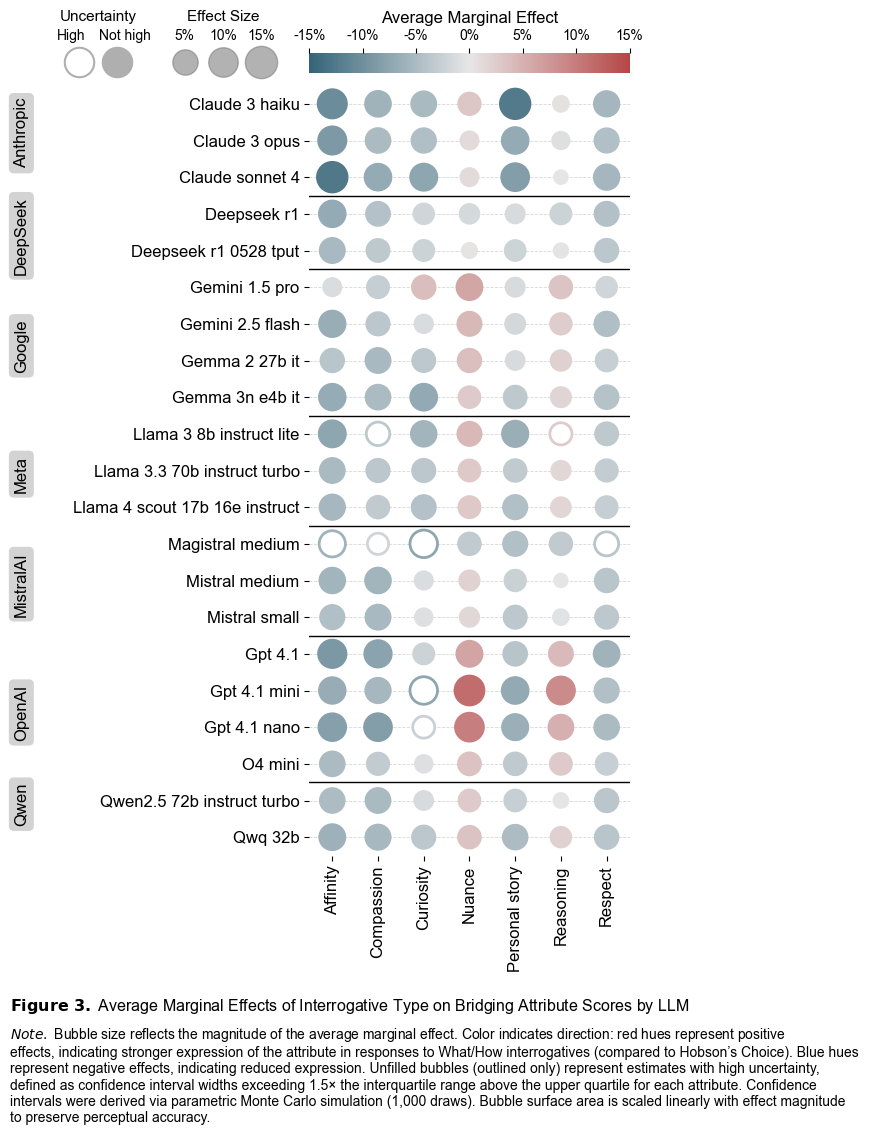

In [8]:
##############################################
# Study 2. Create figure 3 with average marginal effects
##############################################

# (1) Setup & load data
mfx_main_df = pd.read_csv(os.path.join(RESULTS_PATH, "marginal_effects_main_specification.csv"))

mpl.rcParams['font.family'] = 'Arial'

custom_div_cmap = LinearSegmentedColormap.from_list(
    "custom_diverging", ["#356479", "#e7e7e7", "#B64747"], N=256
)

target_width_in = 4.13
cell_height = 0.9
max_height_in = 10

# (2) Data prep 
df = mfx_main_df.copy()
provider_map = all_models_df[['model_name', 'model_provider']].drop_duplicates()
df = df.merge(provider_map, on='model_name', how='left')

# (3) Clean provider names
df['model_provider'] = df['model_provider'].str.capitalize()
df['model_provider'] = df['model_provider'].replace({
    'Openai': 'OpenAI',
    'Deepseek-ai': 'DeepSeek',
    'Meta-llama': 'Meta',
    'Mistral':'MistralAI'
})

# (4) Clean attributes
df['attribute'] = df['attribute'].str.replace("_experimental", "").str.upper()

# (5) Clean model names using sourced function
df['model_name'] = df['model_name'].apply(clean_model_name)

# (6) Calculate CI width
df["ci_width"] = df["conf.high"] - df["conf.low"]

# (7) Flag high uncertainty: CI width outliers by attribute - uses sourced function
df["high_uncertainty"] = (
    df.groupby("attribute")["ci_width"]
    .transform(lambda x: x > x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))
)

# (8) Clean things up
# (a) Ensure alphabetical LLM provider order
provider_order = sorted(df['model_provider'].dropna().unique().tolist())
df['model_provider'] = pd.Categorical(df['model_provider'], categories=provider_order, ordered=True)

# (b) Sort by provider and model
df = df.sort_values(['model_provider', 'model_name'])
df['model_name'] = pd.Categorical(df['model_name'], categories=df['model_name'].unique()[::-1], ordered=True)

# (c) Create pivot table
effect_data = df.pivot(index="model_name", columns="attribute", values="estimate")

# (d) Clean x-axis labels
x_labels = list(effect_data.columns)
x_labels_clean = [label.replace("_", " ").capitalize() for label in x_labels]

# (e) Calculate figure height
fig_height = min(len(effect_data.index) * cell_height + 1.5, max_height_in)

# (9) Plot 
fig, ax = plt.subplots(figsize=(target_width_in, fig_height))
cbar_ax = fig.add_axes([
    ax.get_position().x0,
    ax.get_position().y1 + 0.013,
    ax.get_position().width,
    0.02
])

# (10) Adapt dataformats and further cleaning up
# (a) Long-form data
df_long = df[['model_name', 'attribute', 'estimate', 'high_uncertainty']].copy()
df_long['abs_estimate'] = df_long['estimate'].abs()

x_coords = {attr: i for i, attr in enumerate(x_labels)}
y_labels = list(effect_data.index)
y_coords = {model: i for i, model in enumerate(y_labels)}

df_long['x'] = df_long['attribute'].map(x_coords)
df_long['y'] = df_long['model_name'].map(y_coords)

# (b) Size scaling
size_min, size_max = 50, 500
df_long['size'] = size_min + np.sqrt(df_long['abs_estimate'] / df_long['abs_estimate'].max()) * (size_max - size_min)

# (c) Color scaling
vmin, vmax = -0.15, 0.15
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# (d) Split into two sets for plotting
df_low_uncertainty = df_long[~df_long['high_uncertainty']]
df_high_uncertainty = df_long[df_long['high_uncertainty']]

# (11) Plot normal bubbles
ax.scatter(
    df_low_uncertainty['x'],
    df_low_uncertainty['y'],
    s=df_low_uncertainty['size'],
    c=df_low_uncertainty['estimate'],
    cmap=custom_div_cmap,
    vmin=vmin,
    vmax=vmax,
    alpha=1,
    zorder=2
)

# (12) Plot high-uncertainty bubbles: white fill, colored edge
ax.scatter(
    df_high_uncertainty['x'],
    df_high_uncertainty['y'],
    s=df_high_uncertainty['size'],
    facecolors='white',
    edgecolors=custom_div_cmap(norm(df_high_uncertainty['estimate'])),
    linewidth=2,
    alpha=1,
    zorder=2
)

# (13) Axes 
ax.set_xlim(-0.5, len(x_labels) - 0.5)
ax.set_ylim(-0.5, len(y_labels) - 0.5)

ax.set_xticks(list(x_coords.values()))
ax.set_xticklabels(x_labels_clean, rotation=90, ha="center", va="top", fontsize=12)

for label in ax.get_xticklabels():
    label.set_y(-0.0)

ax.set_yticks(list(y_coords.values()))
ax.set_yticklabels(y_labels, fontsize=12)

ax.set_xlabel(None)
ax.set_ylabel(None)

# (14) Grid 
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
for spine in ax.spines.values():
    spine.set_visible(False)

# (15) Colorbar 
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=custom_div_cmap),
    cax=cbar_ax,
    orientation='horizontal'
)
cbar.ax.tick_params(labelsize=10)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_label("Average Marginal Effect", size=12)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))

# Remove black border around colorbar
cbar.outline.set_visible(False)


# (16) Group Labels 
df['model_name'] = df['model_name'].astype(str)
y_coords_label = {label: tick for tick, label in enumerate(y_labels)}

line_positions, y_positions, seen = [], {}, {}

for i, row in df.iterrows():
    provider = row['model_provider']
    model = row['model_name']
    if provider not in seen:
        if seen:
            prev = list(seen.values())[-1]
            line_positions.append(y_coords_label[model])
            y_positions[list(seen.keys())[-1]] = (prev + y_coords_label[model]) / 2
        seen[provider] = y_coords_label[model]

last_provider = df.iloc[-1]['model_provider']
last_model = df.iloc[-1]['model_name']
y_positions[last_provider] = (seen[last_provider] + y_coords_label[last_model]) / 2

for y in line_positions:
    ax.axhline(y=y + 0.5, color='black', linewidth=1)


for provider, y in y_positions.items():
    # Manually shift Anthropic label upwards because of overlap
    if provider == "Anthropic":
        y = y + 0.3  # adjust this number to increase/decrease space
    
    if provider == "OpenAI" or "Meta":
        y = y + 0.4

    ax.text(
        -0.9, y,
        provider,
        transform=ax.get_yaxis_transform(),
        rotation=90,
        va="center", ha="center",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgrey", edgecolor="none"),
        clip_on=False
    )


#  (17) Bubble Size Legend 
legend_sizes = [0.05, 0.10, 0.15]
legend_labels = [f"{int(s * 100)}%" for s in legend_sizes]
legend_marker_sizes = size_min + np.sqrt(np.array(legend_sizes) / df_long['abs_estimate'].max()) * (size_max - size_min)

legend_x_start = -0.39
legend_y = 1.03
bubble_spacing = 0.12
label_offset = 0.025
title_offset = 0.025

for i, (label, size) in enumerate(zip(legend_labels, legend_marker_sizes)):
    x_pos = legend_x_start + i * bubble_spacing
    ax.scatter(
        x_pos, legend_y,
        s=size,
        color='gray',
        alpha=0.6,
        transform=ax.transAxes,
        clip_on=False
    )
    ax.text(
        x_pos, legend_y + label_offset,
        label,
        transform=ax.transAxes,
        ha='center',
        va='bottom',
        fontsize=10
    )

ax.text(
    legend_x_start + ((len(legend_labels) - 1) * bubble_spacing) / 2,
    legend_y + label_offset + title_offset,
    "Effect Size",
    transform=ax.transAxes,
    fontsize=11,
    ha="center",
    va="bottom"
)


# (18) Uncertainty Legend (Horizontal Layout) 

# (a) Base positions (aligned with Effect Size legend title)
uncertainty_legend_y = legend_y + label_offset + title_offset  # match title height
uncertainty_legend_x_start = legend_x_start - 0.33  # move left of Effect Size legend

bubble_spacing = 0.12             # spacing between bubbles
label_x_offset = 0.025            # extra spacing just for text labels

# (b) Bubble and label for high uncertainty - unfilled, on the left 
x_high = uncertainty_legend_x_start
ax.scatter(
    x_high, legend_y,
    s=legend_marker_sizes[1],  # medium size (10%)
    facecolors='white',
    edgecolors='#B0AFAF',
    linewidth=1.5,
    transform=ax.transAxes,
    clip_on=False,
    zorder=3
)
ax.text(
    x_high - label_x_offset, legend_y + label_offset,  # manually shift text left
    "High",
    transform=ax.transAxes,
    ha='center',
    va='bottom',
    fontsize=10
)

# (c) Bubble and label for low uncertainty - filled on the right
x_low = x_high + bubble_spacing
ax.scatter(
    x_low, legend_y,
    s=legend_marker_sizes[1],
    color="#B0AFAF",
    edgecolors="#B0AFAF",
    linewidth=1.5,
    transform=ax.transAxes,
    clip_on=False,
    zorder=3
)
ax.text(
    x_low + label_x_offset, legend_y + label_offset,  # manually shift text right
    "Not high",
    transform=ax.transAxes,
    ha='center',
    va='bottom',
    fontsize=10
)

# (19) Title centered above both bubbles
ax.text(
    x_high + bubble_spacing / 2,
    uncertainty_legend_y,
    "Uncertainty",
    transform=ax.transAxes,
    fontsize=11,
    ha='center',
    va='bottom'
)


# (20) figure title 
fig.text(
    x=-0.6,
    y=-0.03,
    s=r"$\bf{Figure\ 3.}$ Average Marginal Effects of Interrogative Type on Bridging Attribute Scores by LLM",
    ha='left',
    va='top',
    fontsize=11.5
)

# (21) Add note at teh bottom 
fig.text(
    x=-0.6,
    y=-0.11,  # Adjust as needed
    s=r"$\it{Note.}$ Bubble size reflects the magnitude of the average marginal effect. Color indicates direction: red hues represent positive " \
    "\neffects, indicating stronger expression of the attribute in responses to What/How interrogatives (compared to Hobson’s Choice). Blue hues \n" \
    "represent negative effects, indicating reduced expression. Unfilled bubbles (outlined only) represent estimates with high uncertainty, \n" \
    "defined as confidence interval widths exceeding 1.5× the interquartile range above the upper quartile for each attribute. Confidence \n" \
    "intervals were derived via parametric Monte Carlo simulation (1,000 draws). Bubble surface area is scaled linearly with effect magnitude \n" \
    "to preserve perceptual accuracy.",
    ha='left',
    va='center',
    fontsize=10
)

# (22) Save 
if to_save:
    save_path = os.path.join(FIGURES_PATH, "figure_3.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
#Bubble size reflects the magnitude of the average marginal effect. Color indicates direction: red hues denote a higher likelihood of the attribute appearing in 
#responses to What/How interrogatives (compared to Hobson’s Choice), while blue hues indicate a lower likelihood. Unfilled bubbles (outlined only) represent estimates 
# with high uncertainty, identified as confidence interval width outliers (greater than 1.5× the IQR above the upper quartile for each attribute). Confidence intervals 
#were derived via parametric Monte Carlo simulation (1,000 draws). Bubble surface area is scaled linearly with effect magnitude 
#to preserve perceptual accuracy.

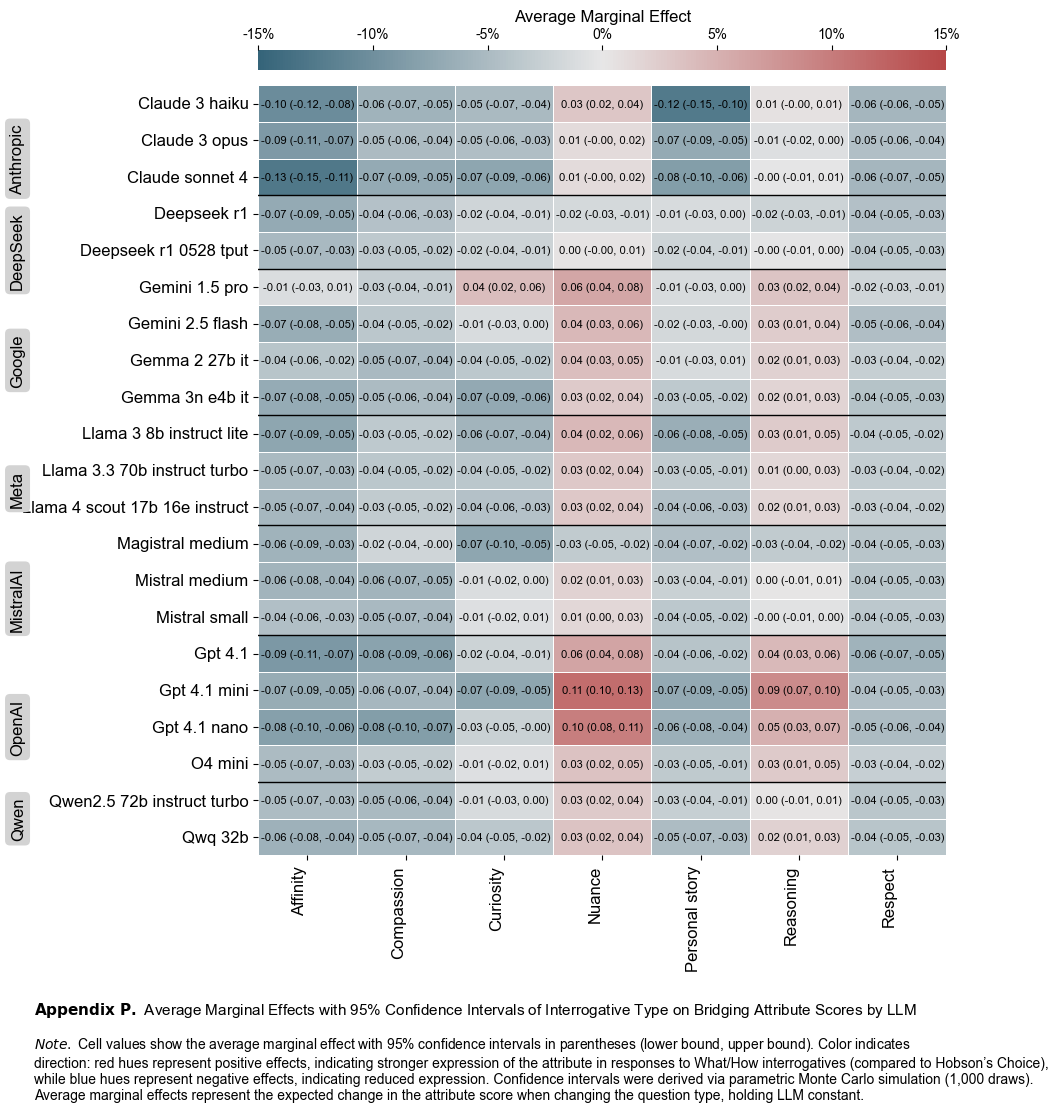

In [ ]:
##############################################
# Study 2. Appendix P. Full average marginal effects with uncertainties
##############################################

# (0) Setup 
mpl.rcParams['font.family'] = 'Arial'

custom_div_cmap = LinearSegmentedColormap.from_list(
    "custom_diverging", ["#356479", "#e7e7e7", "#B64747"], N=256
)

target_width_in = 8
cell_height = 0.9
max_height_in = 10

# (1) Data Prep 
df = mfx_main_df.copy()
provider_map = all_models_df[['model_name', 'model_provider']].drop_duplicates()
df = df.merge(provider_map, on='model_name', how='left')

df['model_provider'] = df['model_provider'].str.capitalize().replace({
    'Openai': 'OpenAI',
    'Deepseek-ai': 'DeepSeek',
    'Meta-llama': 'Meta',
    'Mistral': 'MistralAI'
})

df['attribute'] = df['attribute'].str.replace("_experimental", "").str.upper()

# (2) Use sourced function to clean the model names again 
df['model_name'] = df['model_name'].apply(clean_model_name)

# (3) Compute CI width and flag high uncertainty
df["ci_width"] = df["conf.high"] - df["conf.low"]
df["high_uncertainty"] = df.groupby("attribute")["ci_width"].transform(
    lambda x: x > x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))
)

# (4) Preserve original provider order like for the other figure
provider_order = [
    "Anthropic", "DeepSeek", "Google", "Meta", "MistralAI", "OpenAI", "Qwen"
]
df['model_provider'] = pd.Categorical(df['model_provider'], categories=provider_order, ordered=True)
df = df.sort_values(['model_provider', 'model_name'])
df['model_name'] = pd.Categorical(df['model_name'], categories=df['model_name'].unique(), ordered=True)


# (5) Pivot for heatmap values and annotations
effect_data = df.pivot(index="model_name", columns="attribute", values="estimate")
annotations_df = df.pivot(index="model_name", columns="attribute")

annotations = annotations_df.apply(
    lambda x: x['estimate'].map(lambda est: f"{est:.2f}") + " (" +
              x['conf.low'].map(lambda lo: f"{lo:.2f}") + ", " +
              x['conf.high'].map(lambda hi: f"{hi:.2f}") + ")",
    axis=1
)

x_labels = list(effect_data.columns)
x_labels_clean = [label.replace("_", " ").capitalize() for label in x_labels]
fig_height = min(len(effect_data.index) * cell_height + 1.5, max_height_in)


# (6) Plot 
fig, ax = plt.subplots(figsize=(target_width_in, fig_height))

# (7) Shift plot left just enough to make room for provider labels
plt.subplots_adjust(left=0.13, right=0.99)  # Adjust only slightly

# (8) Colorbar axis
cbar_ax = fig.add_axes([
    ax.get_position().x0,
    ax.get_position().y1 + 0.015,
    ax.get_position().width,
    0.02
])

# (9) Heatmap
vmin, vmax = -0.15, 0.15
hm = sns.heatmap(
    effect_data,
    annot=False,
    cmap=custom_div_cmap,
    center=0,
    vmin=vmin,
    vmax=vmax,
    linewidths=0.5,
    linecolor="white",
    cbar=False,
    ax=ax
)

# (10) Annotations inside squares
for y_idx, y_label in enumerate(effect_data.index):
    for x_idx, x_label in enumerate(effect_data.columns):
        val = annotations.loc[y_label, x_label]
        ax.text(
            x_idx + 0.5, y_idx + 0.5,
            val,
            ha="center", va="center",
            fontsize=8,
            color="black"
        )

# (11) Colorbar 
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=custom_div_cmap),
    cax=cbar_ax,
    orientation='horizontal'
)
cbar.ax.tick_params(labelsize=10)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_label("Average Marginal Effect", size=12)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))
cbar.outline.set_visible(False)

# (12) Axis Labels 
ax.set_xticklabels(x_labels_clean, rotation=90, ha="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xlabel(None)
ax.set_ylabel(None)

# (13) Group Labels 
df['model_name'] = df['model_name'].astype(str)
y_labels = list(effect_data.index)
y_coords_label = {label: tick for tick, label in enumerate(y_labels)}
line_positions, y_positions, seen = [], {}, {}

for i, row in df.iterrows():
    provider = row['model_provider']
    model = row['model_name']
    if provider not in seen:
        if seen:
            prev = list(seen.values())[-1]
            line_positions.append(y_coords_label[model])
            y_positions[list(seen.keys())[-1]] = (prev + y_coords_label[model]) / 2
        seen[provider] = y_coords_label[model]

last_provider = df.iloc[-1]['model_provider']
last_model = df.iloc[-1]['model_name']
y_positions[last_provider] = (seen[last_provider] + y_coords_label[last_model]) / 2

for y in line_positions:
    ax.axhline(y=y, color='black', linewidth=1)

# (14) Tighter alignment with heatmap
for provider, y in y_positions.items():
    ax.text(
        -0.35, y + 0.5,  # Much closer to the heatmap
        provider,
        transform=ax.get_yaxis_transform(),
        rotation=90,
        va="center", ha="center",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgrey", edgecolor="none"),
        clip_on=False
    )

# (15) Title 
fig.text(
    x=-0.15,
    y=-0.035,
    s=r"$\bf{Appendix\ P.}$ Average Marginal Effects with 95% Confidence Intervals of Interrogative Type on Bridging Attribute Scores by LLM",
    ha='left',
    va='top',
    fontsize=11
)

# (16) Add note 
fig.text(
    x=-0.15,
    y=-0.07,
    s=r"$\it{Note.}$ Cell values show the average marginal effect with 95% confidence intervals in parentheses "
      "(lower bound, upper bound). Color indicates \ndirection: red hues represent positive effects, indicating stronger expression of the attribute in responses to What/How interrogatives "
      "(compared to Hobson’s Choice), \nwhile blue hues represent negative effects, indicating reduced expression. Confidence intervals "
      "were derived via parametric Monte Carlo simulation (1,000 draws). \nAverage marginal effects represent the expected change in the attribute score when changing the question type, holding LLM constant.",
    ha='left',
    va='top',
    fontsize=10
)

# (17) Save 
if to_save:
    save_path = os.path.join(APPENDICES_PATH, "appendix_p.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()
